<h1>Shopee Kaggle Competition<h1>

## 1. Basic pre-processing and EDA

In [29]:
#importing necessary packages
import pandas as pd
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
import PIL
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.applications import EfficientNetB4
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
import preprocessor as p
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.neighbors import NearestNeighbors
import PIL
from PIL import Image, ImageDraw
import tensorflow_hub as hub
import tensorflow_text as text
from nltk.corpus import stopwords , wordnet

In [4]:
#loading shopee data
shopee = pd.read_csv("/Users/seshu/Desktop/shoppee project/train.csv")

In [5]:
#displaying shopee data
shopee

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069
...,...,...,...,...,...
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533
34247,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...,4101248785
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013


In [6]:
#group by label group to see count of images
classes_cnt = shopee['label_group'].value_counts().sort_values(ascending=False)
classes_cnt

994676122     51
562358068     51
3627744656    51
3113678103    51
1163569239    51
              ..
119853508      2
2223231779     2
603126590      2
3657310108     2
53836859       2
Name: label_group, Length: 11014, dtype: int64

In [7]:
#converting to a dataframe
classes_df = pd.DataFrame({'Label id':classes_cnt.index, 'Images':classes_cnt.values})

In [8]:
#displaying the data for the image count of each label_id
classes_df

,Label id,Images
0,994676122,51
1,562358068,51
2,3627744656,51
3,3113678103,51
4,1163569239,51
...,...,...
11009,119853508,2
11010,2223231779,2
11011,603126590,2
11012,3657310108,2


In [9]:
#most common image count in a class
classes_df['Images'].value_counts().idxmax()

2

In [10]:
#count of unique classes
len(pd.unique(shopee['label_group']))

11014

In [11]:
#count of classes with images equal to two
len(classes_df[classes_df['Images']==2])

6979

In [15]:
#grouping the entire dataset by labels and selecting label and posting columns
df = shopee.groupby('label_group', as_index=False).agg(list)
df = df[['label_group', 'posting_id']]

In [16]:
#creating duplicate
shopee2 = shopee

In [17]:
#merging the grouped dataset to original dataset based on label id
shopee2 = pd.merge(shopee2, df, on='label_group')

#renaming columns
shopee2.rename(columns = {"posting_id_x":"posting_id"}, inplace = True)
shopee2.rename(columns = {"posting_id_y":"matches"}, inplace = True)

In [18]:
#displaying the dataset
shopee2

,posting_id,image,image_phash,title,label_group,matches
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_2278313361,f83b49a86a0ee8592e3bf0204da3fbdf.jpg,ac63931c3d4b42f6,PAPER BAG VICTORIA SECRET,249114794,"[train_129225211, train_2278313361]"
2,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
3,train_3423213080,8cbe4bf9706bc177fd61071ef776be8c.jpg,bfc6d01bc72c1d30,Double Tape VHB 3M ORIGINAL 12mm x 4.5mm Busa ...,2937985045,"[train_3386243561, train_3423213080]"
4,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
...,...,...,...,...,...,...
34245,train_2743870047,fd97a173d7c60d27e6459fe586797864.jpg,eb7f430dbc8190d8,KedaungHome Cangkir Doreng Latte KI-LATTE,1313560418,"[train_866113781, train_2743870047]"
34246,train_2244662893,fd68da190e8739150321d72eeab52c0d.jpg,f86d8171759c3519,LAMPU HURUF A-Z DAN ANGKA 0-9 \xe2\x9d\xa4\xef...,763032672,"[train_2244662893, train_3281898016]"
34247,train_3281898016,fe2f96d129e71efb924e490ce60df52f.jpg,e23381108bed7df4,LAMPU HURUF A-Z DAN ANGKA 0-9 TINGGI 16 CM,763032672,"[train_2244662893, train_3281898016]"
34248,train_4221982820,ff512b2f4ff8bb431bf089e87c212922.jpg,f94186ff8fa6b010,Sprei Lady Rose 180x200 King terlaris Keroppi,53836859,"[train_4221982820, train_4063409014]"


## 2. Loading Image data

In [19]:
#path where the images are stored
PATH = '/Users/seshu/Desktop/shoppee project/train_images'

In [20]:
#appending path to the image id in that particular row
x = PATH + '/' + shopee.image

In [21]:
#displaying the first path
x[0]

'/Users/seshu/Desktop/shoppee project/train_images/0000a68812bc7e98c42888dfb1c07da0.jpg'

In [22]:
#adding the path column into the dataframe
shopee2['path'] = PATH + '/' + shopee.image
shopee2

,posting_id,image,image_phash,title,label_group,matches,path
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]",/Users/seshu/Desktop/shoppee project/train_ima...
1,train_2278313361,f83b49a86a0ee8592e3bf0204da3fbdf.jpg,ac63931c3d4b42f6,PAPER BAG VICTORIA SECRET,249114794,"[train_129225211, train_2278313361]",/Users/seshu/Desktop/shoppee project/train_ima...
2,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]",/Users/seshu/Desktop/shoppee project/train_ima...
3,train_3423213080,8cbe4bf9706bc177fd61071ef776be8c.jpg,bfc6d01bc72c1d30,Double Tape VHB 3M ORIGINAL 12mm x 4.5mm Busa ...,2937985045,"[train_3386243561, train_3423213080]",/Users/seshu/Desktop/shoppee project/train_ima...
4,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]",/Users/seshu/Desktop/shoppee project/train_ima...
...,...,...,...,...,...,...,...
34245,train_2743870047,fd97a173d7c60d27e6459fe586797864.jpg,eb7f430dbc8190d8,KedaungHome Cangkir Doreng Latte KI-LATTE,1313560418,"[train_866113781, train_2743870047]",/Users/seshu/Desktop/shoppee project/train_ima...
34246,train_2244662893,fd68da190e8739150321d72eeab52c0d.jpg,f86d8171759c3519,LAMPU HURUF A-Z DAN ANGKA 0-9 \xe2\x9d\xa4\xef...,763032672,"[train_2244662893, train_3281898016]",/Users/seshu/Desktop/shoppee project/train_ima...
34247,train_3281898016,fe2f96d129e71efb924e490ce60df52f.jpg,e23381108bed7df4,LAMPU HURUF A-Z DAN ANGKA 0-9 TINGGI 16 CM,763032672,"[train_2244662893, train_3281898016]",/Users/seshu/Desktop/shoppee project/train_ima...
34248,train_4221982820,ff512b2f4ff8bb431bf089e87c212922.jpg,f94186ff8fa6b010,Sprei Lady Rose 180x200 King terlaris Keroppi,53836859,"[train_4221982820, train_4063409014]",/Users/seshu/Desktop/shoppee project/train_ima...


In [23]:
#converting label_group to string
shopee2['label'] = shopee2['label_group'].astype(str)

In [26]:
#loading the images into train generator
batch_size = 32
target_shape=(192,192)

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = datagen.flow_from_dataframe(
        dataframe = shopee2,
        x_col = "path",
        y_col = "label",
        target_size = target_shape,
        class_mode = "sparse",
        batch_size = batch_size
)

Found 34250 validated image filenames belonging to 11014 classes.


## 3. Vectorizing image data using EfficientNetB4 model

In [27]:
#loading the 'EfficientNetB4' model
pre_model = tf.keras.applications.EfficientNetB4(
    include_top = False,
    input_shape = (192, 192, 3),
    pooling = 'max',
    weights = 'imagenet',
    classes= 11014)

pre_model.summary()

2022-08-14 03:46:54.827264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 192, 192, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 192, 192, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 192, 192, 3)  0           ['normalization[0][0

 ivation)                                                                                         
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 97, 97, 144)  0          ['block2a_expand_activation[0][0]
 g2D)                                                            ']                               
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 48, 48, 144)  1296       ['block2a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 48, 48, 144)  576        ['block2a_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block2c_activation (Activation  (None, 48, 48, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2c_se_reshape[0][0]']     
          

 )                                                                                                
                                                                                                  
 block3a_se_squeeze (GlobalAver  (None, 192)         0           ['block3a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3a_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block3a_se_squeeze[0][0]']     
                                                                                                  
 block3a_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block3a_se_reshape[0][0]']     
                                                                                                  
 block3a_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block3a_se_reduce[0][0]']      
          

                                                                                                  
 block3c_se_excite (Multiply)   (None, 24, 24, 336)  0           ['block3c_activation[0][0]',     
                                                                  'block3c_se_expand[0][0]']      
                                                                                                  
 block3c_project_conv (Conv2D)  (None, 24, 24, 56)   18816       ['block3c_se_excite[0][0]']      
                                                                                                  
 block3c_project_bn (BatchNorma  (None, 24, 24, 56)  224         ['block3c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3c_drop (Dropout)         (None, 24, 24, 56)   0           ['block3c_project_bn[0][0]']     
          

                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 12, 12, 112)  37632       ['block4a_se_excite[0][0]']      
                                                                                                  
 block4a_project_bn (BatchNorma  (None, 12, 12, 112)  448        ['block4a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, 12, 12, 672)  75264       ['block4a_project_bn[0][0]']     
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, 12, 12, 672)  2688       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                  'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, 12, 12, 672)  75264       ['block4c_add[0][0]']            
                                                                                                  
 block4d_expand_bn (BatchNormal  (None, 12, 12, 672)  2688       ['block4d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4d_expand_activation (Act  (None, 12, 12, 672)  0          ['block4d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4d_d

 ization)                                                                                         
                                                                                                  
 block4f_expand_activation (Act  (None, 12, 12, 672)  0          ['block4f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4f_dwconv (DepthwiseConv2  (None, 12, 12, 672)  6048       ['block4f_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4f_bn (BatchNormalization  (None, 12, 12, 672)  2688       ['block4f_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block5b_activation (Activation  (None, 12, 12, 960)  0          ['block5b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5b_se_squeeze (GlobalAver  (None, 960)         0           ['block5b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5b_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5b_se_squeeze[0][0]']     
                                                                                                  
 block5b_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5b_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block5d_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5d_se_squeeze[0][0]']     
                                                                                                  
 block5d_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5d_se_reshape[0][0]']     
                                                                                                  
 block5d_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5d_se_reduce[0][0]']      
                                                                                                  
 block5d_se_excite (Multiply)   (None, 12, 12, 960)  0           ['block5d_activation[0][0]',     
                                                                  'block5d_se_expand[0][0]']      
          

                                                                                                  
 block5f_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5f_se_reduce[0][0]']      
                                                                                                  
 block5f_se_excite (Multiply)   (None, 12, 12, 960)  0           ['block5f_activation[0][0]',     
                                                                  'block5f_se_expand[0][0]']      
                                                                                                  
 block5f_project_conv (Conv2D)  (None, 12, 12, 160)  153600      ['block5f_se_excite[0][0]']      
                                                                                                  
 block5f_project_bn (BatchNorma  (None, 12, 12, 160)  640        ['block5f_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_project_bn (BatchNorma  (None, 6, 6, 272)   1088        ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 6, 6, 272)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 6, 6, 272)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 6, 6, 1632)   443904      ['block6b_add[0][0]']            
          

                                                                                                  
 block6d_add (Add)              (None, 6, 6, 272)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block6e_expand_conv (Conv2D)   (None, 6, 6, 1632)   443904      ['block6d_add[0][0]']            
                                                                                                  
 block6e_expand_bn (BatchNormal  (None, 6, 6, 1632)  6528        ['block6e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6e_expand_activation (Act  (None, 6, 6, 1632)  0           ['block6e_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 block6g_expand_bn (BatchNormal  (None, 6, 6, 1632)  6528        ['block6g_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6g_expand_activation (Act  (None, 6, 6, 1632)  0           ['block6g_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6g_dwconv (DepthwiseConv2  (None, 6, 6, 1632)  40800       ['block6g_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6g_b

 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 6, 6, 1632)  14688       ['block7a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, 6, 6, 1632)  6528        ['block7a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block7a_activation (Activation  (None, 6, 6, 1632)  0           ['block7a_bn[0][0]']             
 )                                                                                                
          

In [ ]:
#passing the training data
pred = pre_model.predict(train_generator)

In [32]:
#confirming the length of predictions
len(pred)

34250

In [34]:
#converting the predictions to a dataframe
pred = pd.DataFrame(pred)

In [35]:
#displaying the predictions
pred

,0,1,2,3,4,5,6,7,8,9,...,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791
0,4.434974,3.280804,2.570105,4.800725,2.966969,2.438930,3.049979,1.499081,4.907979,2.666570,...,6.077583,5.438903,2.609642,2.532687,1.474331,5.611214,2.907098,2.266064,1.326471,3.637428
1,4.501625,3.298292,2.361498,4.913359,2.834395,2.366153,3.067879,1.505391,4.834669,2.592195,...,5.971014,5.430171,2.616434,2.392902,1.409776,5.582988,2.861054,2.119602,1.285059,3.588195
2,4.442584,3.309649,2.425833,4.880054,2.882135,2.412420,3.068999,1.504767,4.853658,2.626987,...,6.011926,5.446360,2.631481,2.455430,1.421197,5.608892,2.883744,2.173033,1.303119,3.620606
3,4.403570,3.260714,2.426843,4.839246,2.911358,2.404092,3.063154,1.508113,4.857394,2.617370,...,6.027133,5.431772,2.599398,2.454422,1.432206,5.655732,2.896953,2.218455,1.321705,3.603666
4,4.521805,3.334855,2.364256,4.914109,2.819235,2.357662,3.059930,1.486838,4.839708,2.588778,...,5.976734,5.406781,2.605026,2.377162,1.366122,5.566477,2.849110,2.118757,1.274116,3.586388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34245,4.471371,3.308691,2.445941,4.919087,2.937512,2.417314,3.095324,1.535392,4.904937,2.654850,...,6.067973,5.490645,2.656744,2.473057,1.471104,5.650059,2.906189,2.200615,1.314873,3.658846
34246,4.364473,3.226676,2.517409,4.778444,3.054317,2.461394,3.111265,1.550570,4.868019,2.691732,...,6.099926,5.501589,2.670606,2.554730,1.518598,5.732756,2.934916,2.276340,1.407878,3.655232
34247,4.434926,3.229057,2.379918,4.870752,2.886991,2.407403,3.074413,1.496658,4.815804,2.584641,...,6.009967,5.427438,2.583525,2.465681,1.438147,5.629699,2.906998,2.226279,1.314472,3.607538
34248,4.435458,3.266362,2.418468,4.851394,2.894351,2.398792,3.055265,1.510920,4.844585,2.616961,...,5.998998,5.422019,2.599409,2.459451,1.437267,5.623764,2.894188,2.197542,1.308150,3.593141


## 4. Defining Nearest Neighbour and using it on the 'Image embedded data only'

In [364]:
#defining nearest neighbour and fitting it on the image embedded data
#image_embedding = pred
kneigh2 = NearestNeighbors(n_neighbors=5,leaf_size=5000,algorithm='kd_tree')
kneigh2.fit(image_embedding)

NearestNeighbors(algorithm='kd_tree', leaf_size=5000)

In [365]:
#defining function to retrieve the indexes of the five closest neighbours to any given observation
def getNeighbours2(query_emb):
    neighbors2=[]
    neigh_dist,neigh_ind = kneigh2.kneighbors(X=query_emb.reshape(1,-1), n_neighbors=5, return_distance=True)
    for ind in neigh_ind:
        for ind1 in ind:
            neighbors2.append(str(ind1))
    return neighbors2

In [366]:
#saving the first observation of training set in a variable
query2 = image_embedding[0]

#calling the function
neighbors2 = getNeighbours2(query2)

#printing the indexes of the nearest neighbours
neighbors2

['0', '16630', '5296', '22251', '20664']

In [369]:
#retrieving the original observations based on the above indexes
matching2 = []
for i in range(0,5):
    x = int(neighbors2[i])
    y = shopee3.iloc[x]
    matching2.append(y)
matching2 = pd.DataFrame(matching2)
matching2 = matching2.reset_index()
matching2

,index,posting_id,image,image_phash,title,label_group,matches,path,label,clean
0,0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]",train_images/0000a68812bc7e98c42888dfb1c07da0.jpg,249114794,paper bag victoria secret
1,16630,train_4227076793,7c12e14aac49a65aa43767093f91beaf.jpg,caa4e35a921ab667,Troley troli lipat bawa aqua galon dan gas tro...,2136371395,"[train_4179102634, train_4227076793]",train_images/7c12e14aac49a65aa43767093f91beaf.jpg,2136371395,troley troli lipat bawa aqua galon dan gas tro...
2,5296,train_1345018152,098f2a10e97ab1ba18875777f857b9fa.jpg,b886c77d86c275c2,\xe3\x80\x96IN STOCK/COD\xe3\x80\x97Bicycle Ha...,4028846606,"[train_1345018152, train_3207102998]",train_images/098f2a10e97ab1ba18875777f857b9fa.jpg,4028846606,xe3 x80 x96in stock cod xe3 x80 x97bicycle ha...
3,22251,train_2170044922,c70d614b2b465a33abd45a9bc0b19d61.jpg,bfc0c03f69f026c9,Topi fedora jerami polos dewasa kualitas import,3551572849,"[train_1004591235, train_2170044922]",train_images/c70d614b2b465a33abd45a9bc0b19d61.jpg,3551572849,topi fedora jerami polos dewasa kualitas import
4,20664,train_3953757093,3e2df97db68727873ab13515cd070f4f.jpg,b96d9296c496c669,MAX Creamer 500gr (Non Dairy Creamer),1079705715,"[train_3953757093, train_99764720, train_29364...",train_images/3e2df97db68727873ab13515cd070f4f.jpg,1079705715,max creamer 500gr non dairy creamer


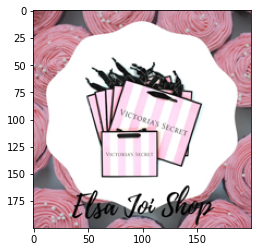

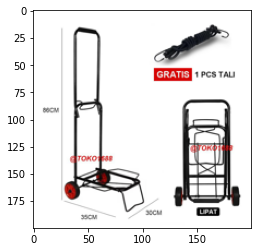

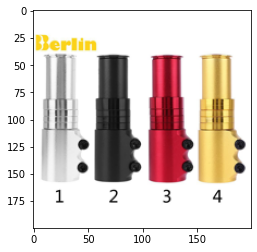

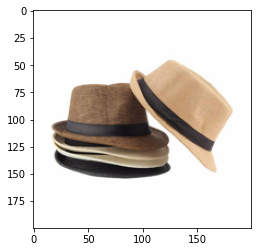

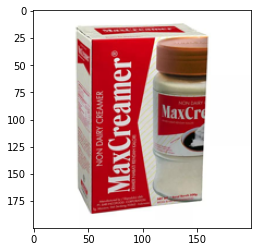

In [370]:
#printing the images based on the indexes retrieved
for i in range(0,5):
    image_path = matching2.iloc[i]['path']
    image = Image.open(image_path)
    image = image.resize((200,200)) 
    plt.figure()
    plt.imshow(image)

## 5. Loading text data and vectorizing using tf-idf

In [37]:
#retrieving text column into a new dataframe
shopee_text = shopee[["title"]]

In [38]:
#displaying the dataframe
shopee_text

,title
0,Paper Bag Victoria Secret
1,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO..."
2,Maling TTS Canned Pork Luncheon Meat 397 gr
3,Daster Batik Lengan pendek - Motif Acak / Camp...
4,Nescafe \xc3\x89clair Latte 220ml
...,...
34245,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...
34246,MamyPoko Pants Royal Soft - S 70 - Popok Celana
34247,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...
34248,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S..."


In [39]:
def clean_text(text):
    
    '''This functions performs basic cleaning such as removal of numbers, spaces, special characters etc..'''
    
    temp = tweet.lower()
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = re.sub(' +', ' ', temp)
    temp = temp.strip()
    #removing numbers
    pattern = r'[0-9]'
    temp = re.sub(pattern, '', temp) 
    
    return temp

In [40]:
#removing stopping words
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None
shopee_text['clean'] = shopee_text['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /Users/seshu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
#applying the clean_text function
shopee_text['clean'] = [clean_text(tw) for tw in shopee_text['clean']]

In [42]:
#performing lemmitization  
lemmatizer = WordNetLemmatizer()
shopee_text['clean'] = [lemmatizer.lemmatize(tw) for tw in shopee_text['clean']]

In [43]:
#displaying the clean column
shopee_text.head(5)

,title,clean
0,Paper Bag Victoria Secret,paper bag victoria secret
1,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",double tape m vhb mm x original double foam...
2,Maling TTS Canned Pork Luncheon Meat 397 gr,maling tts canned pork luncheon meat gr
3,Daster Batik Lengan pendek - Motif Acak / Camp...,daster batik lengan pendek motif acak campur l...
4,Nescafe \xc3\x89clair Latte 220ml,nescafe xc xclair latte ml


In [44]:
#applying tf-idf to vectorize the data
model = TfidfVectorizer(stop_words='english')
text_embeddings = model.fit_transform(shopee_text['clean'])

#printing the shape of the text_embeddings
print('text embeddings shape',text_embeddings.shape)

text embeddings shape (34250, 19310)


In [45]:
#printing the type of the variable
text_embeddings

<34250x19310 sparse matrix of type '<class 'numpy.float64'>'
	with 253048 stored elements in Compressed Sparse Row format>

## 6. Defining Nearest Neighbour and using it on the 'Text embedded data only'

In [70]:
#defining nearest neighbour and fitting it on the text embedded data
kneigh = NearestNeighbors(n_neighbors=5,leaf_size=5000,algorithm='brute')
kneigh.fit(text_embeddings)

NearestNeighbors(algorithm='brute', leaf_size=5000)

In [71]:
#defining function to retrieve the indexes of the five closest neighbours to any given observation
def getNeighbours(query):
    
    '''This function takes a particular observation and returns the closets five observations index as a list'''
    
    neighbors=[]
    neigh_dist,neigh_ind = kneigh.kneighbors(X=query.reshape(1,-1), n_neighbors=5, return_distance=True)
    for i in neigh_ind:
        for j in i:
            neighbors.append(str(j))
    return neighbors

In [72]:
#saving the first observation of training set in a variable
query = text_embeddings[0]

#calling the function
neighbors = getNeighbours(query)

In [73]:
#printing the indexes of the nearest neighbours
neighbors

['1', '0', '18144', '27292', '21917']

In [74]:
#retrieving the original observations based on the above indexes
matching = []
for i in range(0,5):
    x = int(neighbors[i])
    y = shopee3.iloc[x]
    matching.append(y)

In [75]:
#saving the list of observations created above as a datarame
matching = pd.DataFrame(matching)

In [76]:
#resetting the index and printing the dataframe
matching = matching.reset_index()
matching

,index,posting_id,image,image_phash,title,label_group,matches,path,label,clean
0,1,train_2278313361,f83b49a86a0ee8592e3bf0204da3fbdf.jpg,ac63931c3d4b42f6,PAPER BAG VICTORIA SECRET,249114794,"[train_129225211, train_2278313361]",/Users/seshu/Desktop/shoppee project/train_ima...,249114794,paper bag victoria secret
1,0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]",/Users/seshu/Desktop/shoppee project/train_ima...,249114794,paper bag victoria secret
2,18144,train_4186142233,7dc030d9bdbed932eb44b6aeccbf9bdb.jpg,f2d3cd0ccc09f07a,[ Gamis Populer ] [ Tya Dress ] [ Maxi Dress ]...,1742550190,"[train_1246092123, train_268805751, train_9857...",/Users/seshu/Desktop/shoppee project/train_ima...,1742550190,
3,27292,train_2105716669,6a48f9615e5e3795d1ef65b8a7c2936f.jpg,be9ce3699eb40a42,#NAME?,2646594309,"[train_2105716669, train_589283887, train_3875...",/Users/seshu/Desktop/shoppee project/train_ima...,2646594309,
4,21917,train_3982974369,454a6c3fa03be8f4ed699084dddd2ce5.jpg,ca078c9893b3dae3,PAPER BAG THE BODY SHOP,471581622,"[train_3982974369, train_1147731811]",/Users/seshu/Desktop/shoppee project/train_ima...,471581622,paper bag the body shop


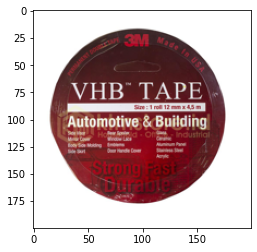

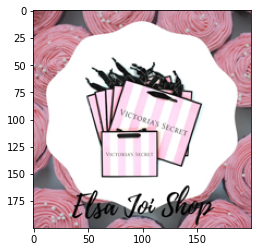

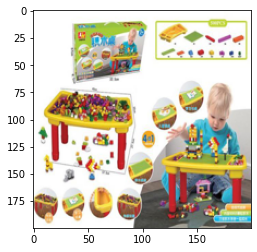

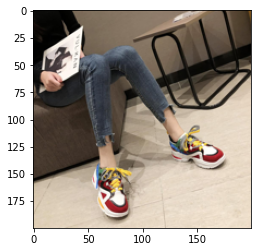

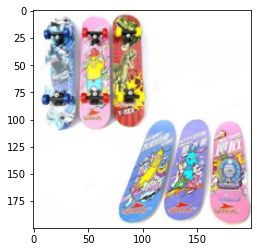

In [77]:
#printing the images based on the indexes retrieved
for i in range(0,5):
    image_path = matching.iloc[i]['path']
    image = Image.open(image_path)
    image = image.resize((200,200)) 
    plt.figure()
    plt.imshow(image)
     

## 8. Loading test data and merging with training data

In [27]:
#reading the test dataframe
test = pd.read_csv("test.csv")
test

,posting_id,image,image_phash,title
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng


In [29]:
#labeling as 'NA' for label_group column
test['label_group']='na'

In [30]:
#displaying image id's
test['image']

0    0006c8e5462ae52167402bac1c2e916e.jpg
1    0007585c4d0f932859339129f709bfdc.jpg
2    0008377d3662e83ef44e1881af38b879.jpg
Name: image, dtype: object

In [31]:
#saving path for test images
TEST_PATH = 'test_images'

In [32]:
#adding a column for the path to each test image
test['path'] = TEST_PATH + '/' + test['image']

#displaying the test dataset
test

,posting_id,image,image_phash,title,label_group,path
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...,na,test_images/0006c8e5462ae52167402bac1c2e916e.jpg
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...,na,test_images/0007585c4d0f932859339129f709bfdc.jpg
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng,na,test_images/0008377d3662e83ef44e1881af38b879.jpg


In [35]:
#appending the dataset to training dataset
shopee3 = test.append(shopee2, ignore_index=True)

C:\Users\sandh\AppData\Local\Temp\ipykernel_12508\1055335824.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shopee3 = test.append(shopee2, ignore_index=True)


In [36]:
#displaying the dataset
shopee3

,posting_id,image,image_phash,title,label_group,path
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...,na,test_images/0006c8e5462ae52167402bac1c2e916e.jpg
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...,na,test_images/0007585c4d0f932859339129f709bfdc.jpg
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng,na,test_images/0008377d3662e83ef44e1881af38b879.jpg
3,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,train_images/0000a68812bc7e98c42888dfb1c07da0.jpg
4,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,train_images/00039780dfc94d01db8676fe789ecd05.jpg
...,...,...,...,...,...,...
34248,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725,train_images/fff1c07ceefc2c970a7964cfb81981c5.jpg
34249,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533,train_images/fff401691371bdcb382a0d9075dfea6a.jpg
34250,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...,4101248785,train_images/fff421b78fa7284284724baf249f522e.jpg
34251,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013,train_images/fff51b87916dbfb6d0f8faa01bee67b8.jpg


In [38]:
def clean_text(text):
    
    '''This functions performs basic cleaning such as removal of numbers, spaces, special characters etc..'''
    
    temp = tweet.lower()
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = re.sub(' +', ' ', temp)
    temp = temp.strip()
    #removing numbers
    pattern = r'[0-9]'
    temp = re.sub(pattern, '', temp) 
    
    return temp

In [39]:
#removing stopping words
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None
shopee3['clean'] = shopee3['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sandh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
#applying the clean_text function
shopee3['clean'] = [clean_tweet(tw) for tw in shopee3['clean']]

In [42]:
#performing lemmatization 
lemmatizer = WordNetLemmatizer()
shopee3['clean'] = [lemmatizer.lemmatize(tw) for tw in shopee3['clean']]

In [43]:
#displaying the head of the dataframe
shopee3.head(5)

,posting_id,image,image_phash,title,label_group,path,clean
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...,na,test_images/0006c8e5462ae52167402bac1c2e916e.jpg,edufuntoys character phone ada lampu dan mus...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...,na,test_images/0007585c4d0f932859339129f709bfdc.jpg,beli 1 free spatula masker komedo blackhea...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng,na,test_images/0008377d3662e83ef44e1881af38b879.jpg,ready lemonilo mie instant sehat kuah dan goreng
3,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,train_images/0000a68812bc7e98c42888dfb1c07da0.jpg,paper bag victoria secret
4,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,train_images/00039780dfc94d01db8676fe789ecd05.jpg,double tape 3m vhb 12 mm x 4 5 original doub...


In [44]:
#vectorizing the whole data
model = TfidfVectorizer(stop_words='english')
text_embeddings = model.fit_transform(shopee3['clean'])

In [45]:
#final text embeddings for train and test data
text_embeddings

<34253x24655 sparse matrix of type '<class 'numpy.float64'>'
	with 273616 stored elements in Compressed Sparse Row format>

## 9. Performing Nearest Neighbors on text embedded data (train and test) and Testing for the test set

In [46]:
#defining nearest neighbour and fitting it on the text embedded data
kneigh = NearestNeighbors(n_neighbors=5,leaf_size=5000,algorithm='brute')
kneigh.fit(text_embeddings)

NearestNeighbors(algorithm='brute', leaf_size=5000)

In [47]:
#defining function to retrieve the indexes of the five closest neighbours to any given observation
def getNeighbours(query):
    neighbors=[]
    neigh_dist,neigh_ind = kneigh.kneighbors(X=query.reshape(1,-1), n_neighbors=5, return_distance=True)
    for i in neigh_ind:
        for j in i:
            neighbors.append(str(j))
    return neighbors

In [54]:
#saving the first test image in a variable
query = text_embeddings[0]

#calling the function
neighbors = getNeighbours(query)

['0', '16700', '29989', '24703', '21511']

In [55]:
#retrieving the original observations based on the above indexes
matching = []
for i in range(0,5):
    x = int(neighbors[i])
    y = shopee3.iloc[x]
    matching.append(y)
    
#saving the list of observations created above as a datarame    
matching = pd.DataFrame(matching)
matching = matching.reset_index()
matching

,index,posting_id,image,image_phash,title,label_group,path,clean
0,0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...,na,test_images/0006c8e5462ae52167402bac1c2e916e.jpg,edufuntoys character phone ada lampu dan mus...
1,16700,train_4186142233,7dc030d9bdbed932eb44b6aeccbf9bdb.jpg,f2d3cd0ccc09f07a,[ Gamis Populer ] [ Tya Dress ] [ Maxi Dress ]...,1742550190,train_images/7dc030d9bdbed932eb44b6aeccbf9bdb.jpg,
2,29989,train_3943548077,e07c1c50cf8de8a247f93239368a4848.jpg,f992126b25de0be4,Mainan musik anak / Mainan Bayi Tongkat Rattle...,2693722838,train_images/e07c1c50cf8de8a247f93239368a4848.jpg,mainan musik anak mainan bayi tongkat rattle...
3,24703,train_4228394397,b918ccfbb3a3d29b6e498e63eccba7e0.jpg,fac1843e95607ae6,Mainan Anak musik animal piano farm lampu,555497581,train_images/b918ccfbb3a3d29b6e498e63eccba7e0.jpg,mainan anak musik animal piano farm lampu
4,21511,train_2086264821,a19324756f5d77671bf783fa1063569a.jpg,fe4cca1ab025c9cb,[CUCI GUDANG] Edufuntoys - GO FISHING import o...,118145987,train_images/a19324756f5d77671bf783fa1063569a.jpg,edufuntoys go fishing import original main...


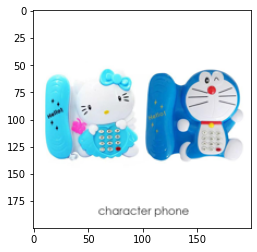

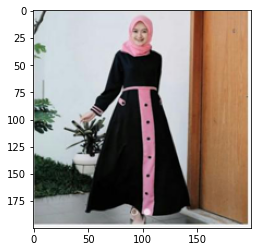

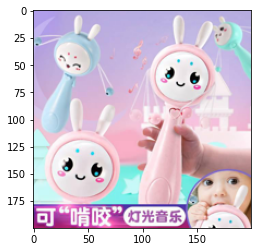

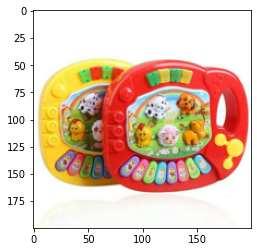

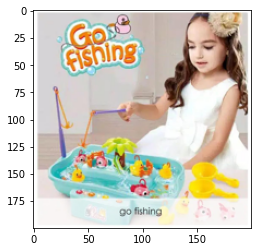

In [56]:
#printing the images based on the indexes retrieved
for i in range(0,5):
    image_path = matching.iloc[i]['path']
    image = Image.open(image_path)
    image = image.resize((200,200)) 
    plt.figure()
    plt.imshow(image)
     

In [57]:
#saving the second test image in a variable
query = text_embeddings[1]

#calling the function
neighbors = getNeighbours(query)

['1', '16700', '8116', '25564', '30375']

In [58]:
#retrieving the original observations based on the above indexes
matching = []
for i in range(0,5):
    x = int(neighbors[i])
    y = shopee3.iloc[x]
    matching.append(y)
    
#saving the list of observations created above as a datarame     
matching = pd.DataFrame(matching)
matching = matching.reset_index()
matching

,index,posting_id,image,image_phash,title,label_group,path,clean
0,1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...,na,test_images/0007585c4d0f932859339129f709bfdc.jpg,beli 1 free spatula masker komedo blackhea...
1,16700,train_4186142233,7dc030d9bdbed932eb44b6aeccbf9bdb.jpg,f2d3cd0ccc09f07a,[ Gamis Populer ] [ Tya Dress ] [ Maxi Dress ]...,1742550190,train_images/7dc030d9bdbed932eb44b6aeccbf9bdb.jpg,
2,8116,train_1254316111,3d3de93dca63de535a81625570b11820.jpg,a619f9f230168d8f,Miniso Official Flawless Matte Lip cream,3733574563,train_images/3d3de93dca63de535a81625570b11820.jpg,miniso official flawless matte lip cream
3,25564,train_617595972,bf5aad615d38215a33f54dce90ec7bff.jpg,f2bf508dc145da0b,"b""Pond's Flawless White Night Cream 10 gr""",2636308092,train_images/bf5aad615d38215a33f54dce90ec7bff.jpg,b pond s flawless white night cream 10 gr
4,30375,train_3417232270,e3187b423ba8db9d4e567f5d2f6acb81.jpg,f2bf508dc145da0b,"b""Pond'S Flawless White Night Cream 10G""",2636308092,train_images/e3187b423ba8db9d4e567f5d2f6acb81.jpg,b pond s flawless white night cream 10g


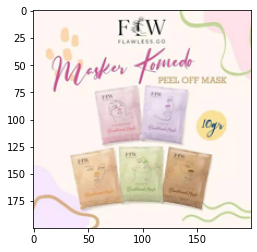

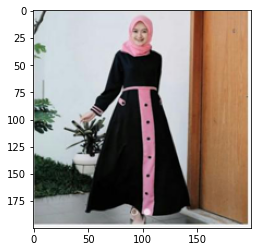

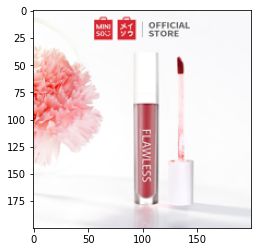

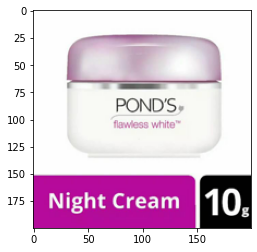

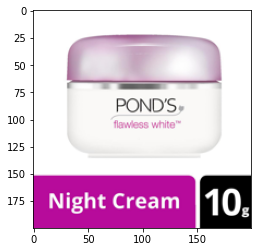

In [59]:
#printing the images based on the indexes retrieved
for i in range(0,5):
    image_path = matching.iloc[i]['path']
    image = Image.open(image_path)
    image = image.resize((200,200)) 
    plt.figure()
    plt.imshow(image)
     

In [60]:
#saving the third test image in a variable
query = text_embeddings[2]

#calling the function
neighbors = getNeighbours(query)
neighbors

['2', '33892', '20453', '7054', '11970']

In [61]:
#retrieving the original observations based on the above indexes
matching = []
for i in range(0,5):
    x = int(neighbors[i])
    y = shopee3.iloc[x]
    matching.append(y)
    
#saving the list of observations created above as a datarame 
matching = pd.DataFrame(matching)
matching = matching.reset_index()
matching

,index,posting_id,image,image_phash,title,label_group,path,clean
0,2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng,na,test_images/0008377d3662e83ef44e1881af38b879.jpg,ready lemonilo mie instant sehat kuah dan goreng
1,33892,train_2895779112,fd4ded3cbfa2019ecfe680f3ee276a91.jpg,91ea64b3856c38d7,Lemonilo Mie GORENG & KUAH Instant Sehat 70gr ...,3123493047,train_images/fd4ded3cbfa2019ecfe680f3ee276a91.jpg,lemonilo mie goreng kuah instant sehat 70gr ...
2,20453,train_3341330490,998ddd1fd4ba143ed832719cf994827e.jpg,bb86c469f1a42e1b,Lemonilo Mie Goreng Instant Sehat - Mie Organic,1537696988,train_images/998ddd1fd4ba143ed832719cf994827e.jpg,lemonilo mie goreng instant sehat mie organic
3,7054,train_33320904,356b48432b16923d69b144a9ac5bb35a.jpg,8396253fc63d49b1,Lemonilo Mie Goreng Instant Sehat - Mie Organic,1537696988,train_images/356b48432b16923d69b144a9ac5bb35a.jpg,lemonilo mie goreng instant sehat mie organic
4,11970,train_325825603,5a1a5788c2db263b05349e73beb5d24f.jpg,bb86c468d1b42e9b,Lemonilo Mie Kuah dan Goreng Instant Sehat Org...,1537696988,train_images/5a1a5788c2db263b05349e73beb5d24f.jpg,lemonilo mie kuah dan goreng instant sehat org...


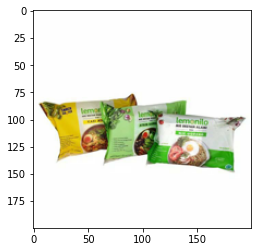

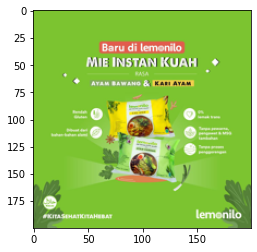

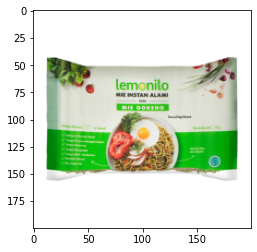

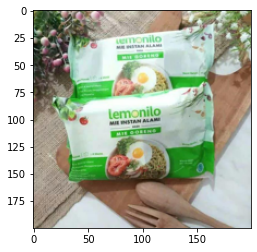

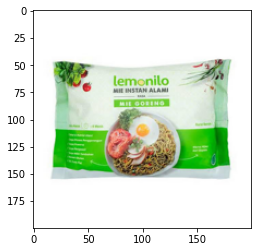

In [62]:
#printing the images based on the indexes retrieved
for i in range(0,5):
    image_path = matching.iloc[i]['path']
    image = Image.open(image_path)
    image = image.resize((200,200)) 
    plt.figure()
    plt.imshow(image)

## 10. Validating image embedded test data using nearest neighbour model fitted over image embedded data

In [374]:
#displaying test dataset
test

,posting_id,image,image_phash,title,path
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...,test_images/0006c8e5462ae52167402bac1c2e916e.jpg
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...,test_images/0007585c4d0f932859339129f709bfdc.jpg
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng,test_images/0008377d3662e83ef44e1881af38b879.jpg


In [436]:
#loading test images
batch_size = 32
target_shape=(192,192)

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_generator = datagen.flow_from_dataframe(
        dataframe = test,
        x_col = "image",
        directory='test_images/',
        target_size = target_shape,
        class_mode = None,
        batch_size = batch_size
)

Found 3 validated image filenames.


In [437]:
#vectorizing test images using efficientnet model
pred_test = pre_model.predict(test_generator)

1/1 [==============================] - 2s 2s/step


In [474]:
#displaying the predicted array
pred_test

array([[4.521369 , 3.3224654, 2.3970006, ..., 2.1414783, 1.2832109,
        3.6246617],
       [4.431291 , 3.2678268, 2.4004812, ..., 2.2101743, 1.3184589,
        3.6086516],
       [4.499593 , 3.2991428, 2.3727732, ..., 2.1312118, 1.282034 ,
        3.5924022]], dtype=float32)

In [442]:
#saving the first test image data in a variable
query_emb = pred_test[0]

#calling the function
postingid_list = getNeighbours2(query_emb)
postingid_list

['9820', '27274', '5545', '31937', '30893']

In [443]:
#retrieving the original observations based on the above indexes
test_matching0 = []
for i in range(0,5):
    x = int(postingid_list[i])
    y = shopee3.iloc[x]
    test_matching0.append(y)
test_matching0 = pd.DataFrame(test_matching0)
test_matching0 = test_matching0.reset_index()
test_matching0

,index,posting_id,image,image_phash,title,label_group,matches,path,label,clean
0,9820,train_3806044521,14eb92abcac5e849b5ad95e4fcd6e629.jpg,e49bc67130cc9b66,Proclin Bottle 1000ml,690199618,"[train_3806044521, train_644041448]",train_images/14eb92abcac5e849b5ad95e4fcd6e629.jpg,690199618,proclin bottle 1000ml
1,27274,train_3681127485,9d8ae2a1b2c5a0c1ddc7ad225ecf79fe.jpg,aceed291936a6cc4,Tenda anak perempuan laki-laki murah,487927457,"[train_2504152429, train_3681127485]",train_images/9d8ae2a1b2c5a0c1ddc7ad225ecf79fe.jpg,487927457,tenda anak perempuan laki laki murah
2,5545,train_3060042113,2fe9ec44d3b58ac340cb7f286761f687.jpg,d6a9acc6f315b206,Yummy Bites Organic Noodle 200gr,3299506042,"[train_2222000918, train_2459679680, train_227...",train_images/2fe9ec44d3b58ac340cb7f286761f687.jpg,3299506042,yummy bites organic noodle 200gr
3,31937,train_2686627319,a45f665b9f403b9f4c1fdc55d6551a0d.jpg,95b1f54fd608c346,SH1942 sepatu sandal flat boots tali fashion k...,1218868039,"[train_2686627319, train_3798711468]",train_images/a45f665b9f403b9f4c1fdc55d6551a0d.jpg,1218868039,sh1942 sepatu sandal flat boots tali fashion k...
4,30893,train_1244136943,93f1712ac50526a93cfd023a4769bde8.jpg,ca35a2de4989a59e,Alvin.store123 BAJU TIDUR PIYAMA Hp EMBOS PREM...,196545328,"[train_1244136943, train_4014057720]",train_images/93f1712ac50526a93cfd023a4769bde8.jpg,196545328,alvin store123 baju tidur piyama hp embos prem...


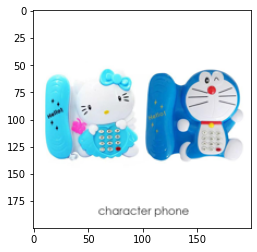

In [444]:
#printing the image that is being tested for
image_path = test.iloc[0]['path']
image = Image.open(image_path)
image = image.resize((200,200)) 
plt.figure()
plt.imshow(image)

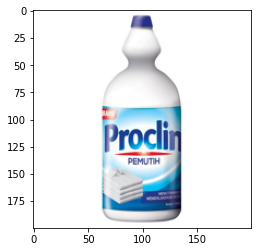

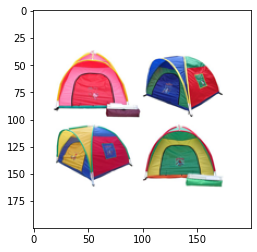

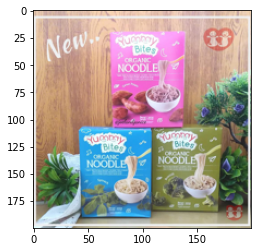

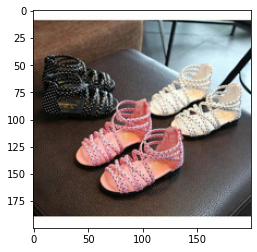

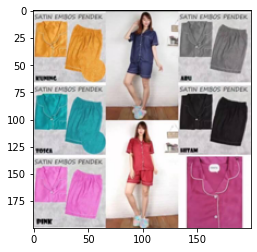

In [445]:
#printing the images based on the indexes retrieved
for i in range(0,5):
    image_path = test_matching0.iloc[i]['path']
    image = Image.open(image_path)
    image = image.resize((200,200)) 
    plt.figure()
    plt.imshow(image)

In [446]:
#saving the second test image data in a variable
query_emb = pred_test[1]

#calling the function
postingid_list = getNeighbours2(query_emb)
postingid_list

['14878', '6236', '27939', '8326', '20812']

In [447]:
#retrieving the original observations based on the above indexes
test_matching1 = []
for i in range(0,5):
    x = int(postingid_list[i])
    y = shopee3.iloc[x]
    test_matching1.append(y)
test_matching1 = pd.DataFrame(test_matching1)
test_matching1 = test_matching1.reset_index()
test_matching1

,index,posting_id,image,image_phash,title,label_group,matches,path,label,clean
0,14878,train_3719418971,24693fc4be47a451a97258cadd03e2ea.jpg,ba9c1cc12b631ef4,Botol Susu Sumo Murah BPA Free 240 Ml/120 Ml /...,3799823061,"[train_3719418971, train_1659872699]",train_images/24693fc4be47a451a97258cadd03e2ea.jpg,3799823061,botol susu sumo murah bpa free 240 ml 120 ml ...
1,6236,train_770430318,cbe0f1377d6954c149856b78a4a5fa52.jpg,9b91e46a9477985c,Souvenir gantungan kunci wayang rama sinta / s...,1934657835,"[train_1092092312, train_770430318]",train_images/cbe0f1377d6954c149856b78a4a5fa52.jpg,1934657835,souvenir gantungan kunci wayang rama sinta s...
2,27939,train_2500863221,9ae938078c8100a71d3247e186490ef7.jpg,e631989e89ce6731,Mascara wand satuan,3346181780,"[train_3721448969, train_2500863221]",train_images/9ae938078c8100a71d3247e186490ef7.jpg,3346181780,mascara wand satuan
3,8326,train_1314668292,10f3435bbe32fcf8f7e6c91ff9fba8b8.jpg,e79cda36c9246299,READY STOCK!!! MESES CERES CLASSIC CHOCOLATE K...,3854760594,"[train_1314668292, train_2556317633]",train_images/10f3435bbe32fcf8f7e6c91ff9fba8b8.jpg,3854760594,ready stock meses ceres classic chocolate k...
4,20812,train_3128525426,65b1005248e0ab5541fbf4721ffcfcef.jpg,fa85857ac47aa3c1,PROMO SALE MUKENA RAYON BALI TERUSAN TRAVELLI...,2982802404,"[train_2645479590, train_3128525426]",train_images/65b1005248e0ab5541fbf4721ffcfcef.jpg,2982802404,promo sale mukena rayon bali terusan travellin...


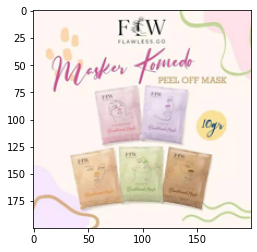

In [448]:
#printing the image that is being tested for
image_path = test.iloc[1]['path']
image = Image.open(image_path)
image = image.resize((200,200)) 
plt.figure()
plt.imshow(image)

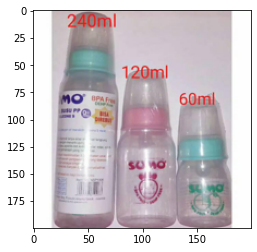

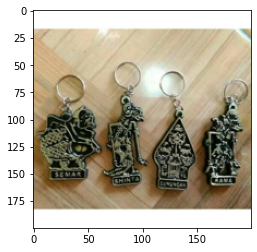

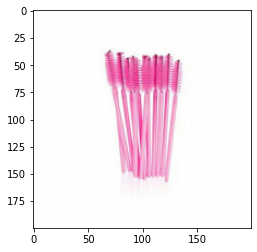

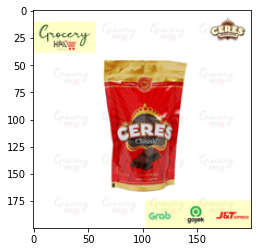

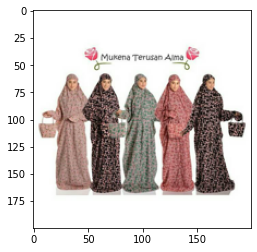

In [449]:
#printing the images based on the indexes retrieved
for i in range(0,5):
    image_path = test_matching1.iloc[i]['path']
    image = Image.open(image_path)
    image = image.resize((200,200)) 
    plt.figure()
    plt.imshow(image)

In [450]:
#saving the third test image data in a variable
query_emb = pred_test[2]

#calling the function
postingid_list = getNeighbours2(query_emb)
postingid_list

['11102', '79', '30444', '31505', '18952']

In [451]:
#retrieving the original observations based on the above indexes
test_matching2 = []
for i in range(0,5):
    x = int(postingid_list[i])
    y = shopee3.iloc[x]
    test_matching2.append(y)
test_matching2 = pd.DataFrame(test_matching2)
test_matching2 = test_matching2.reset_index()
test_matching2

,index,posting_id,image,image_phash,title,label_group,matches,path,label,clean
0,11102,train_3505542013,69ecb704e7ce71422ecbbaed2c74db61.jpg,fb2e4621714e96b1,Madu Lambung Herbal Obat Herbal Asam Lambung A...,2684150012,"[train_3711919709, train_2651778363, train_308...",train_images/69ecb704e7ce71422ecbbaed2c74db61.jpg,2684150012,madu lambung herbal obat herbal asam lambung a...
1,79,train_3550051722,ba9f2f61c42543d37648574e29e69386.jpg,eaa4c019b5639dd9,[CH88] STAND HANGER BERDIRI - STAND HANGER MUL...,4044205497,"[train_1872347548, train_998519723, train_1760...",train_images/ba9f2f61c42543d37648574e29e69386.jpg,4044205497,stand hanger berdiri stand hanger multifun...
2,30444,train_606787439,ef5dd7d9ffe93bbc4601afe6245dc791.jpg,b39b8c6cccb6c461,[innisfree] Jeju Volcanic Clay Mousse Mask EX ...,3528630234,"[train_2186657187, train_606787439]",train_images/ef5dd7d9ffe93bbc4601afe6245dc791.jpg,3528630234,jeju volcanic clay mousse mask ex 100ml
3,31505,train_733018378,9d3eefbace0d7ce405f889d7969e8735.jpg,d635e902c94b5b6a,JAMSUIT JOLA / JAMSUIT SALUR JOLA,2991455774,"[train_733018378, train_1988012800, train_4518...",train_images/9d3eefbace0d7ce405f889d7969e8735.jpg,2991455774,jamsuit jola jamsuit salur jola
4,18952,train_3672374874,6739bc62a2ac898de9c6c793bc93fa44.jpg,a718c3add8d354b4,Garpu Makan Polos Stainless silver ISI 12 PCS,1251456488,"[train_1224177214, train_1331906253, train_367...",train_images/6739bc62a2ac898de9c6c793bc93fa44.jpg,1251456488,garpu makan polos stainless silver isi 12 pcs


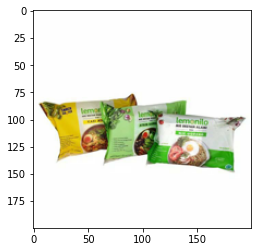

In [452]:
#printing the image that is being tested for
image_path = test.iloc[2]['path']
image = Image.open(image_path)
image = image.resize((200,200)) 
plt.figure()
plt.imshow(image)

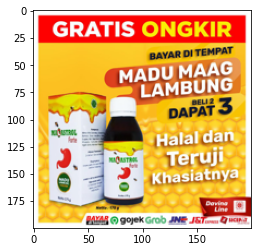

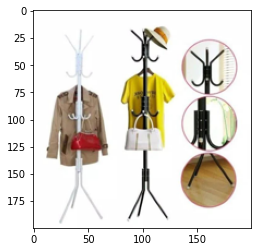

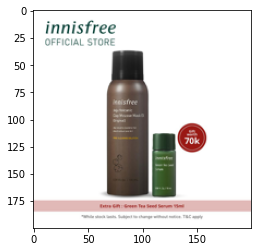

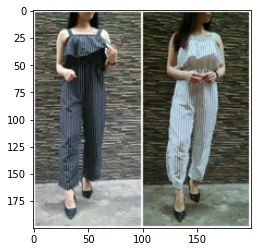

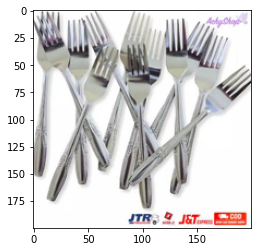

In [453]:
#printing the images based on the indexes retrieved
for i in range(0,5):
    image_path = test_matching2.iloc[i]['path']
    image = Image.open(image_path)
    image = image.resize((200,200)) 
    plt.figure()
    plt.imshow(image)

## 11. Combining the image and text vector datasets

In [161]:
#image embedding variable: pred
#text embedding variable: text_embeddings

In [87]:
#text embeddings variable
text_embeddings

<34250x24655 sparse matrix of type '<class 'numpy.float64'>'
	with 273574 stored elements in Compressed Sparse Row format>

In [88]:
#converting the text_embeddings to array
text_array = text_embeddings.toarray()

#converting the array to dataframe
text_df = pd.DataFrame(text_array) 

In [92]:
#image embeddings variable
pred

array([[4.4349737, 3.2808037, 2.570105 , ..., 2.2660637, 1.326471 ,
        3.6374276],
       [4.5016246, 3.2982917, 2.361498 , ..., 2.1196022, 1.2850586,
        3.5881953],
       [4.442584 , 3.3096495, 2.4258332, ..., 2.173033 , 1.3031188,
        3.6206057],
       ...,
       [4.434926 , 3.229057 , 2.379918 , ..., 2.2262793, 1.3144724,
        3.6075385],
       [4.4354577, 3.2663617, 2.4184678, ..., 2.1975422, 1.3081498,
        3.593141 ],
       [4.465731 , 3.28004  , 2.3815563, ..., 2.121646 , 1.2857805,
        3.6238658]], dtype=float32)

In [93]:
#converting the array to dataframe
image_df = pd.DataFrame(pred)

In [94]:
#shape of the image dataframe
image_df.shape

(34250, 1792)

In [95]:
#merging image and text dataframes
image_text = pd.concat([image_df,text_df],axis = 1)

In [96]:
#shape of the new dataframe
image_text.shape

(34250, 26447)

In [97]:
#convertig the dataframe to array
combined_embedding = np.array(image_text)

In [98]:
#confirming the type
type(combined_embedding)

numpy.ndarray

## 12. Validating testing data using the image+text combined array

## 13. Creating text imbeddings using BERT

In [41]:
#installing required packages
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
#installing required packages
pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
#tensorflow preprocess and encoder URL's for the model uncased L-12_H-768_A-12
preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [43]:
#displaying the clean column
shopee_text.head(5)

,title,clean
0,Paper Bag Victoria Secret,paper bag victoria secret
1,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",double tape m vhb mm x original double foam...
2,Maling TTS Canned Pork Luncheon Meat 397 gr,maling tts canned pork luncheon meat gr
3,Daster Batik Lengan pendek - Motif Acak / Camp...,daster batik lengan pendek motif acak campur l...
4,Nescafe \xc3\x89clair Latte 220ml,nescafe xc xclair latte ml


In [ ]:
#selecting the clean column only
shopee_clean = shopee_text[['clean']]

In [57]:
#selecting the first 1001 records
shopee_clean_10000 = shopee_clean.loc[0:1000]

In [58]:
#shape of the dataset
shopee_clean_10000.shape

(1001, 1)

In [59]:
#converting the data to list
clean_list = list(shopee_clean_10000['clean'])

In [60]:
#displaying the list
clean_list

['paper bag victoria secret',
 'double tape m vhb  mm x   original   double foam tape',
 'maling tts canned pork luncheon meat  gr',
 'daster batik lengan pendek   motif acak   campur   leher kancing  dpt   batik karakter alhadi',
 'nescafe  xc xclair latte ml',
 'celana wanita  bb   kg harem wanita  bisa cod ',
 'jubah anak size   thn',
 'kulot plisket salur  candy plisket  wish kulot premium  kulot pelangi premium hieka kulot',
 '  tempelan kulkas magnet angka  tempelan angka magnet',
 'big sale sepatu pantofel kulit keren kerja kantor laki pria cowok dinas resmi formal pesta kickers',
 'atasan rajut wanita lisdia sweater',
 'pashmina kusut rawis polos crinkle shawl murah banget',
 'pashmina kusut rawis polos crinkle shawl murah banget part ',
 'lampu led t speedometer dashboard motor mobil  speedo bright',
 'charger vizz vz tc   batok charger vizz a original real kapasitas',
 'korek kuping led untuk balita cherrybabykidsshop sp lc',
 'marks   spencer   rose hand   body lotion  ml',


In [61]:
#creating an object for preprocessing using the preprocess URL
preprocess_text = hub.KerasLayer(preprocess)

In [63]:
#preprocessing the list using the above created object
text_preprocessed = preprocess_text(clean_list)
text_preprocessed.keys()

dict_keys(['input_word_ids', 'input_mask', 'input_type_ids'])

In [65]:
#creating an object for encoding using the encoder URL
bert_model = hub.KerasLayer(encoder)

In [66]:
#applying encoding on the list for embedded data
results = bert_model(text_preprocessed)

In [68]:
#displaying the result
result = results['pooled_output']
result

<tf.Tensor: shape=(1001, 768), dtype=float32, numpy=
array([[-0.8229144 , -0.3265564 , -0.02622154, ...,  0.23926245,
        -0.6430905 ,  0.877864  ],
       [-0.8616898 , -0.48877588, -0.84552604, ..., -0.8483557 ,
        -0.63532287,  0.80096954],
       [-0.8402141 , -0.498332  , -0.9226599 , ..., -0.8032842 ,
        -0.65025723,  0.8607498 ],
       ...,
       [-0.82192826, -0.39253116, -0.5883947 , ..., -0.44888756,
        -0.66654974,  0.8326463 ],
       [-0.795936  , -0.40942568, -0.8225682 , ..., -0.5464824 ,
        -0.58236045,  0.6947396 ],
       [-0.72298276, -0.4331695 , -0.86592907, ..., -0.67980534,
        -0.6203201 ,  0.74690944]], dtype=float32)>